In [7]:
from pathlib import Path

# Configure dataset path for local runs (expects folder `cats and dogs` next to this notebook)
data_dir = Path.cwd() / "cats and dogs"
if not data_dir.exists():
    raise FileNotFoundError(f"Dataset folder not found: {data_dir}")

In [8]:
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image
from resizeimage import resizeimage

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, accuracy_score

# Cat and Dog Classification using SVM
<p><img src="https://wtamu.edu/~cbaird/sq/images/dog2.jpg" alt="Dog">
<em>A Dog.</em></p>
<p><img src="https://images.everydayhealth.com/images/lung-respiratory/allergies/hcallergieslivingwithcatarticle.jpg?sfvrsn=898fd1e5_0" alt="Cat">
<em>A Cat.</em></p>

r

In [9]:
# Load images from local dataset directory
def load_images_from_folder(folder_path):
    """Load all images from folder structure: folder/class_name/image.jpg"""
    images = []
    labels = []
    
    class_names = ['cats', 'dogs']
    label_map = {name: idx for idx, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = Path(folder_path) / class_name
        if class_path.exists():
            # Combine all image patterns
            img_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.jpeg')) + list(class_path.glob('*.png'))
            for img_file in img_files:
                try:
                    images.append(str(img_file))
                    labels.append(label_map[class_name])
                except:
                    pass
    
    return images, labels

# importing images from local folder
dataset_path = data_dir
imgs, labels = load_images_from_folder(dataset_path)

# creating labels dataframe
labels_df = pd.DataFrame({'image': imgs, 'label': labels})
print(f"Loaded {len(labels_df)} images")
labels_df.head()

Loaded 2023 images


,image,label
0,c:\Users\ainun\OneDrive\Documents\Citra\uas\ca...,0
1,c:\Users\ainun\OneDrive\Documents\Citra\uas\ca...,0
2,c:\Users\ainun\OneDrive\Documents\Citra\uas\ca...,0
3,c:\Users\ainun\OneDrive\Documents\Citra\uas\ca...,0
4,c:\Users\ainun\OneDrive\Documents\Citra\uas\ca...,0


### Exploring images of dataset
Let's see what kind of images does the dataset provide and see what kind of preprocessing needs to be done.

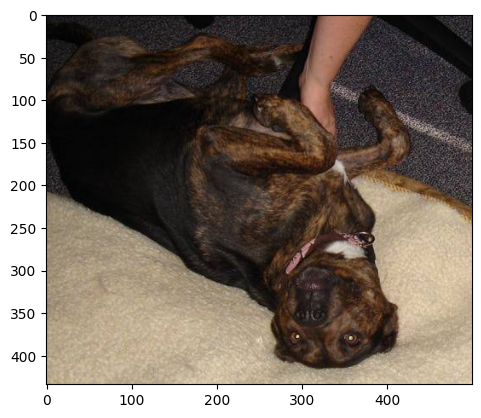

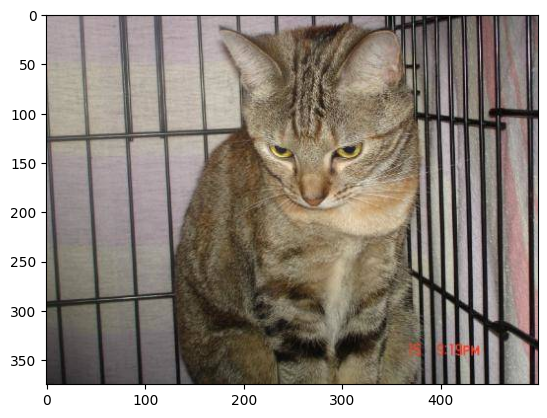

In [10]:
def get_image(path):
    img = Image.open(path)
    return np.array(img)

# showing a dog image
dog_row = labels_df[labels_df.label == 1].reset_index().image[23]
plt.imshow(get_image(dog_row))
plt.show()

# showing a cat image
cat_row = labels_df[labels_df.label == 0].reset_index().image[79]
plt.imshow(get_image(cat_row))
plt.show()

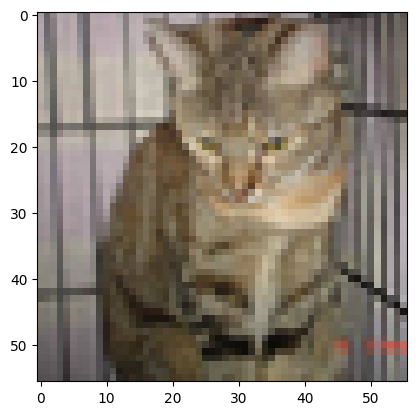

In [11]:
# image manupulation
img = Image.open(cat_row)
img = resizeimage.resize_cover(img, [56, 56])
plt.imshow(np.array(img), cmap='gray')
plt.show()

## Histogram of oriented gradients


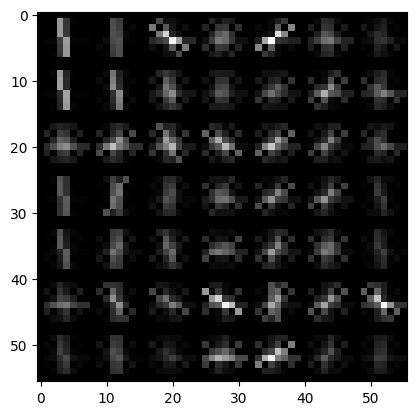

In [12]:
grey_img = rgb2gray(img)
hog_features, hog_img = hog(grey_img, visualize=True, block_norm='L2-Hys', pixels_per_cell=(8,8))
plt.imshow(np.array(hog_img), cmap='gray')
plt.show()

## Create image features and flatten into a single row


In [13]:
def create_features(path):
    img = Image.open(path)
    img = resizeimage.resize_cover(img, [56, 56])
    img_arr = np.array(img)
    # flatten three channel color image
    color_features = img_arr.flatten()
    # convert image to greyscale
    grey_image = rgb2gray(img_arr)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(8, 8))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

dog_features = create_features(dog_row)
print(dog_features.shape)

(11433,)


## Loop over images to preprocess


In [14]:
def create_feature_matrix(label_df):
    features_list = []

    for img_path in labels_df.image:
        # get features for image
        img_features = create_features(img_path)
        features_list.append(img_features)

    feature_matrix = np.array(features_list)
    return feature_matrix

feature_matrix = create_feature_matrix(labels_df)

## Scale feature matrix


In [15]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
imgs_stand = ss.fit_transform(feature_matrix)

Feature matrix shape is:  (2023, 11433)


## Split into train and test sets


In [16]:
X_train, X_test, y_train, y_test = train_test_split(imgs_stand,
                                                    labels_df.label.values,
                                                    test_size=0.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0    714
1    702
Name: count, dtype: int64

## Train model
Memakai SVM classifier dengan linear kernel.

In [17]:
# define support vector classifier
svm = SVC(kernel='linear',probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## Score model


Accuracy: 0.6128500823723229

Precision: 0.6198083067092651
Recall: 0.6258064516129033
F1-score: 0.622792937399679

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.61      0.60      0.60       297
           1       0.62      0.63      0.62       310

    accuracy                           0.61       607
   macro avg       0.61      0.61      0.61       607
weighted avg       0.61      0.61      0.61       607


Confusion Matrix:
 [[178 119]
 [116 194]]
Specificity: 0.5993265993265994


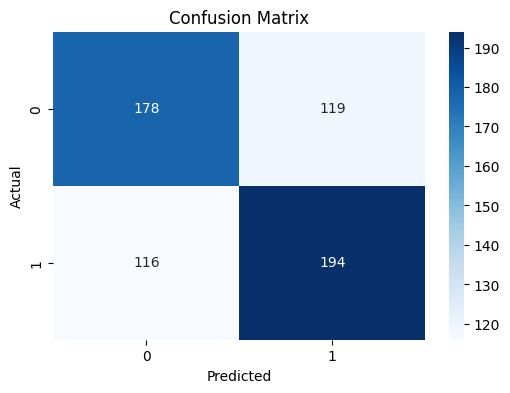

AUC Score: 0.6647768002606712


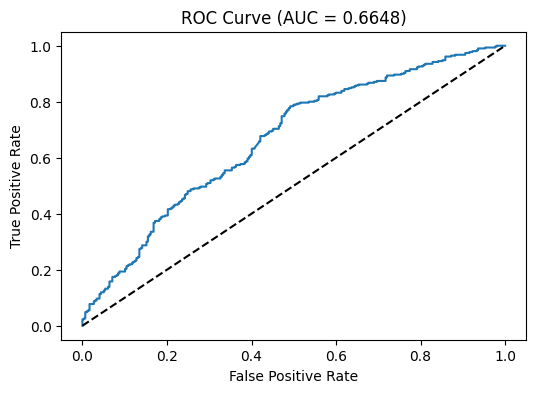

In [18]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# 1. Generate Predictions
# ============================
y_pred = svm.predict(X_test)

# Jika model support probability
try:
    y_prob = svm.predict_proba(X_test)[:, 1]
except:
    # Untuk SVM kernel non-linear tanpa probability -> gunakan decision function
    y_prob = svm.decision_function(X_test)

# ============================
# 2. Akurasi
# ============================
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# ============================
# 3. Precision, Recall, F1-score
# ============================
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# ============================
# 4. Classification Report
# ============================
print("\n===== Classification Report =====")
print(classification_report(y_test, y_pred))

# ============================
# 5. Confusion Matrix + Specificity
# ============================
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

specificity = TN / (TN + FP)

print("\nConfusion Matrix:\n", cm)
print("Specificity:", specificity)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ============================
# 6. ROC Curve + AUC
# ============================
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print("AUC Score:", auc)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AUC = {:.4f})".format(auc))
plt.show()

## Visualizing Predictions


In [25]:
from random import randint

# Reload test images using the same function
test_imgs, test_labels = load_images_from_folder(dataset_path)
imgs = test_imgs
labels = test_labels

Prediction: Cat
Actual: Cat


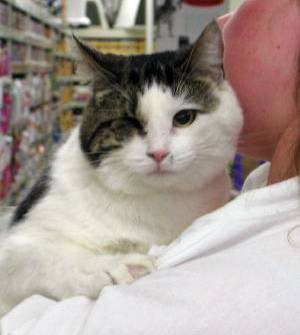

In [26]:
random_ix = randint(0, len(imgs))
label = {0: 'Cat', 1:'Dog'}
rand_img = imgs[random_ix]
# create features of the image
test_features = create_features(rand_img)
# predict
prediction = svm.predict([test_features])
print("Prediction: " + label[prediction[0]])
print("Actual: " + label[labels[random_ix]])
# display image
display(Image.open(rand_img))